In [33]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


In [34]:
image_size = (180, 180)
batch_size = 128

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23442 files belonging to 2 classes.
Using 18754 files for training.
Using 4688 files for validation.


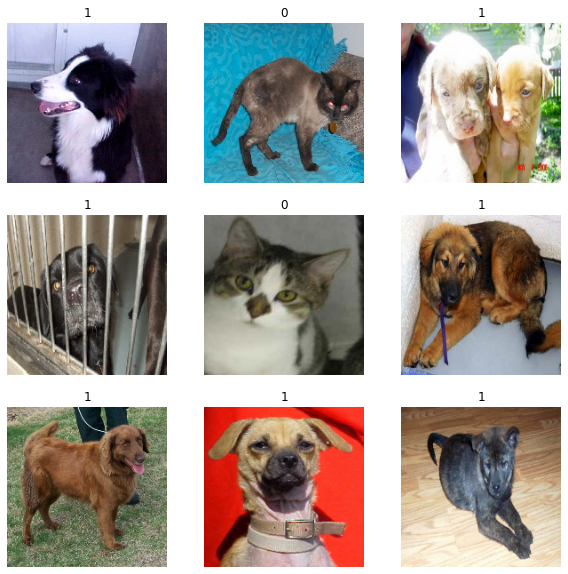

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [36]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

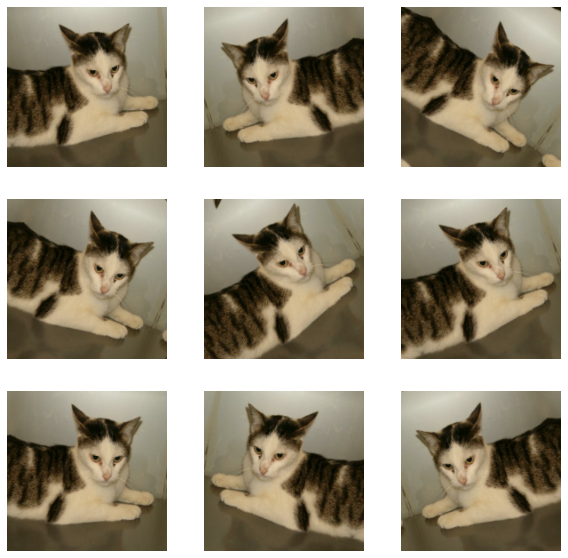

In [37]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [11]:
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
# Rest of the model

NameError: name 'input_shape' is not defined

In [38]:
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))

In [39]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)

# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

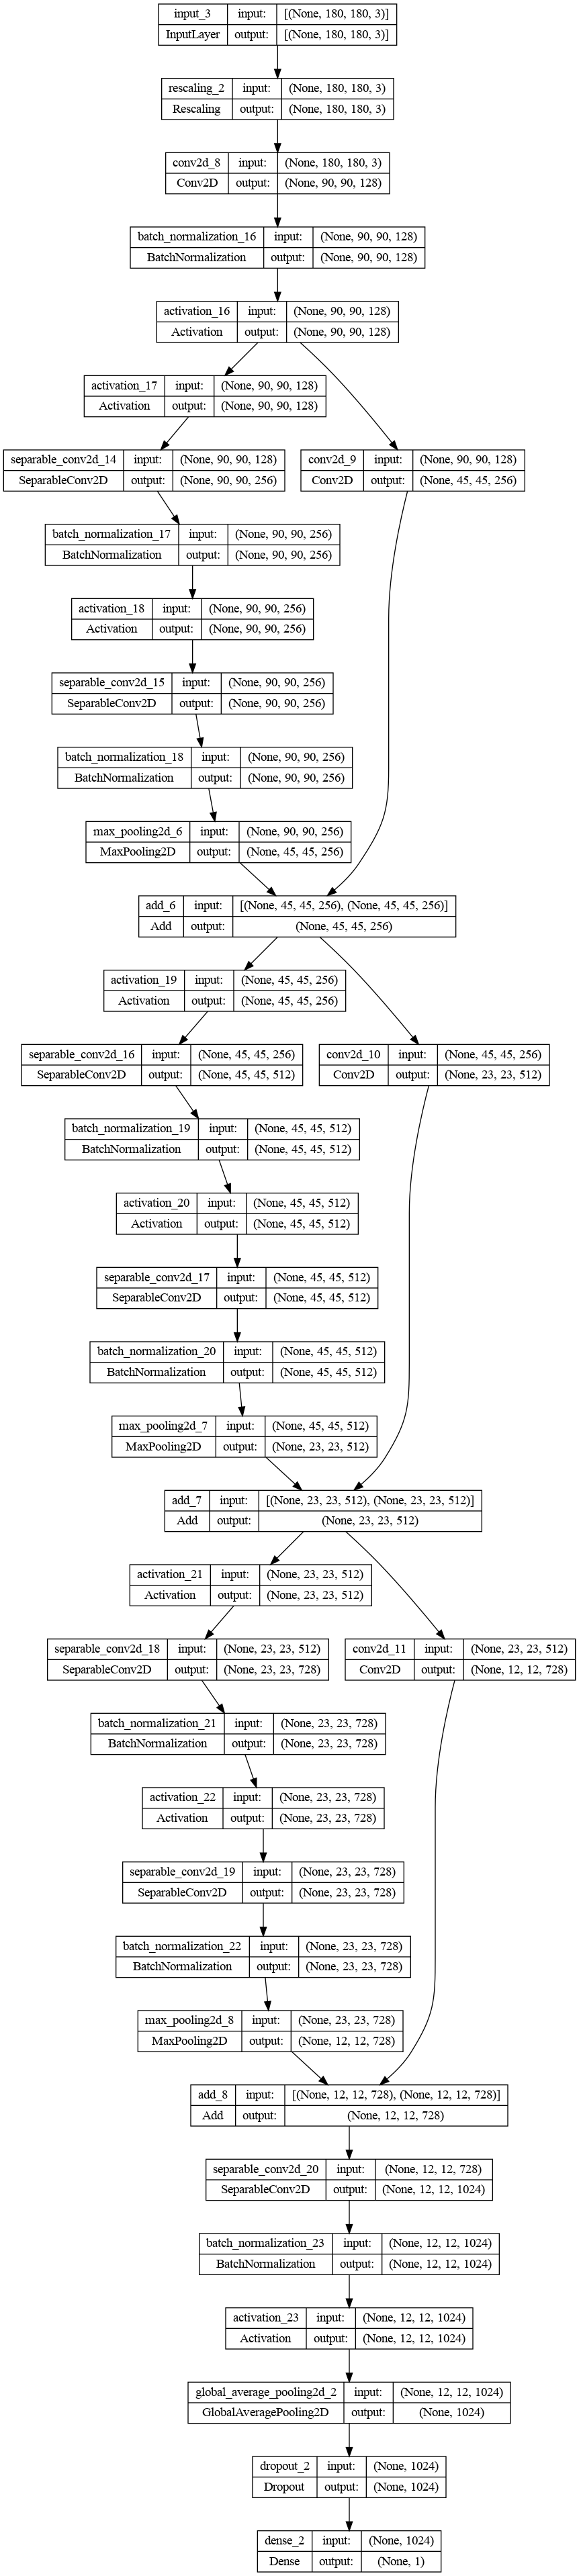

In [40]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)


In [41]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/25


Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
2023-02-14 11:46:33.160264: W tensorflow/tsl/framework/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 506.25MiB (rounded to 530841600)requested by op model_2/batch_normalization_16/FusedBatchNormV3
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-02-14 11:46:33.160363: I tensorflow/tsl/framework/bfc_allocator.cc:1034] BFCAllocator dump for GPU_0_bfc
2023-02-14 11:46:33.160391: I tensorflow/tsl/framework/bfc_allocator.cc:1041] Bin (256): 	Total Chunks: 139, Chunks in use: 139. 34.8KiB allocated for chunks. 34.8KiB in use in bin. 714B client-requested in use in bin.
2023-02-14 11:46:33.160412: I tensorflow/tsl/framework/bfc_allocator.cc:1041] Bin (512): 	Total Chunks: 48, Chunks in use: 47. 24.5KiB allocated for chunks. 23.8KiB in use in 

ResourceExhaustedError: Graph execution error:

Detected at node 'model_2/batch_normalization_16/FusedBatchNormV3' defined at (most recent call last):
    File "/home/hhousseinho/anaconda3/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/hhousseinho/anaconda3/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/hhousseinho/anaconda3/lib/python3.9/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/home/hhousseinho/anaconda3/lib/python3.9/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/home/hhousseinho/anaconda3/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 677, in start
      self.io_loop.start()
    File "/home/hhousseinho/anaconda3/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/home/hhousseinho/anaconda3/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/home/hhousseinho/anaconda3/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/home/hhousseinho/anaconda3/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/hhousseinho/anaconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "/home/hhousseinho/anaconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "/home/hhousseinho/anaconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 367, in dispatch_shell
      await result
    File "/home/hhousseinho/anaconda3/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "/home/hhousseinho/anaconda3/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/home/hhousseinho/anaconda3/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/hhousseinho/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2863, in run_cell
      result = self._run_cell(
    File "/home/hhousseinho/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2909, in _run_cell
      return runner(coro)
    File "/home/hhousseinho/anaconda3/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/hhousseinho/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3106, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/hhousseinho/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3309, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/hhousseinho/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3369, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_7208/2660810289.py", line 11, in <cell line: 11>
      model.fit(
    File "/home/hhousseinho/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/hhousseinho/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/hhousseinho/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/home/hhousseinho/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/hhousseinho/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/home/hhousseinho/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1023, in train_step
      y_pred = self(x, training=True)
    File "/home/hhousseinho/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/hhousseinho/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 561, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/hhousseinho/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/hhousseinho/anaconda3/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/hhousseinho/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/hhousseinho/anaconda3/lib/python3.9/site-packages/keras/engine/functional.py", line 511, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/home/hhousseinho/anaconda3/lib/python3.9/site-packages/keras/engine/functional.py", line 668, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/hhousseinho/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/hhousseinho/anaconda3/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/hhousseinho/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/hhousseinho/anaconda3/lib/python3.9/site-packages/keras/layers/normalization/batch_normalization.py", line 866, in call
      outputs = self._fused_batch_norm(inputs, training=training)
    File "/home/hhousseinho/anaconda3/lib/python3.9/site-packages/keras/layers/normalization/batch_normalization.py", line 659, in _fused_batch_norm
      output, mean, variance = control_flow_util.smart_cond(
    File "/home/hhousseinho/anaconda3/lib/python3.9/site-packages/keras/utils/control_flow_util.py", line 108, in smart_cond
      return tf.__internal__.smart_cond.smart_cond(
    File "/home/hhousseinho/anaconda3/lib/python3.9/site-packages/keras/layers/normalization/batch_normalization.py", line 633, in _fused_batch_norm_training
      return tf.compat.v1.nn.fused_batch_norm(
Node: 'model_2/batch_normalization_16/FusedBatchNormV3'
OOM when allocating tensor with shape[128,128,90,90] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model_2/batch_normalization_16/FusedBatchNormV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_74000]

e at 7f590bcb4700 of size 4096 next 413
2023-02-14 11:46:33.166450: I tensorflow/tsl/framework/bfc_allocator.cc:1090] InUse at 7f590bcb5700 of size 4096 next 414
2023-02-14 11:46:33.166462: I tensorflow/tsl/framework/bfc_allocator.cc:1090] InUse at 7f590bcb6700 of size 4096 next 415
2023-02-14 11:46:33.166473: I tensorflow/tsl/framework/bfc_allocator.cc:1090] InUse at 7f590bcb7700 of size 4096 next 416
2023-02-14 11:46:33.166485: I tensorflow/tsl/framework/bfc_allocator.cc:1090] InUse at 7f590bcb8700 of size 4096 next 417
2023-02-14 11:46:33.166497: I tensorflow/tsl/framework/bfc_allocator.cc:1090] InUse at 7f590bcb9700 of size 4096 next 418
2023-02-14 11:46:33.166508: I tensorflow/tsl/framework/bfc_allocator.cc:1090] InUse at 7f590bcba700 of size 4096 next 419
2023-02-14 11:46:33.166520: I tensorflow/tsl/framework/bfc_allocator.cc:1090] InUse at 7f590bcbb700 of size 4096 next 420
2023-02-14 11:46:33.166532: I tensorflow/tsl/framework/bfc_allocator.cc:1090] InUse at 7f590bcbc700 of siz

2023-02-14 11:46:33.167973: I tensorflow/tsl/framework/bfc_allocator.cc:1090] InUse at 7f5912e01300 of size 512 next 540
2023-02-14 11:46:33.167985: I tensorflow/tsl/framework/bfc_allocator.cc:1090] InUse at 7f5912e01500 of size 512 next 544
2023-02-14 11:46:33.167996: I tensorflow/tsl/framework/bfc_allocator.cc:1090] InUse at 7f5912e01700 of size 512 next 541
2023-02-14 11:46:33.168008: I tensorflow/tsl/framework/bfc_allocator.cc:1090] InUse at 7f5912e01900 of size 512 next 545
2023-02-14 11:46:33.168020: I tensorflow/tsl/framework/bfc_allocator.cc:1090] InUse at 7f5912e01b00 of size 512 next 546
2023-02-14 11:46:33.168031: I tensorflow/tsl/framework/bfc_allocator.cc:1090] InUse at 7f5912e01d00 of size 512 next 547
2023-02-14 11:46:33.168043: I tensorflow/tsl/framework/bfc_allocator.cc:1090] InUse at 7f5912e01f00 of size 4608 next 548
2023-02-14 11:46:33.168055: I tensorflow/tsl/framework/bfc_allocator.cc:1090] InUse at 7f5912e03100 of size 4608 next 549
2023-02-14 11:46:33.168066: I 

In [53]:
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")

1/1 [==============================] - 0s 19ms/step
This image is 50.04% cat and 49.96% dog.
